In [1]:
!pip install adversarial_robustness_toolbox --quiet

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
x_train[0].shape

(28, 28)

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [5]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
optimizer = Adam(learning_rate=0.01)

In [7]:
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])


In [8]:
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5


I0000 00:00:1727996048.247571     106 service.cc:145] XLA service 0x7a5d88002c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727996048.247618     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 69/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3008 - sparse_categorical_accuracy: 0.6160

I0000 00:00:1727996050.524519     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3298 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.0740 - val_sparse_categorical_accuracy: 0.9767
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0872 - val_sparse_categorical_accuracy: 0.9790
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 0.9832
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0591 - val_sparse_categorical_accuracy: 0.9820
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0665 - val_sparse_categorical_accuracy: 0.9838


In [51]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy on clean data before training model on poisoined dataset: {test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8069 - sparse_categorical_accuracy: 0.7231
Test accuracy on clean data before training model on poisoined dataset: 0.7466


In [10]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=SparseCategoricalCrossentropy(), train_step=None)


In [50]:
pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, eps_step=0.01, max_iter=40)

In [ ]:
with tf.device('/device:GPU:0'):
  for epoch in range(5):
      print(f"Epoch {epoch + 1}")
      for i in range(0, len(x_train), 64):
          x_batch = x_train[i:i+64]
          y_batch = y_train[i:i+64]
          x_batch_adv = pgd.generate(x=x_batch)
          model.train_on_batch(x_batch_adv, y_batch)

In [13]:
x_test_adv = pgd.generate(x=x_test)

PGD - Batches: 0it [00:00, ?it/s]

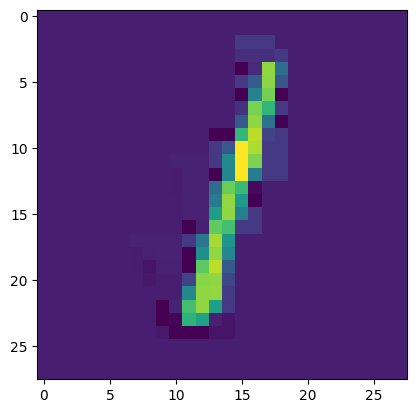

In [47]:
plt.imshow(x_sample.squeeze())

In [ ]:
test_loss_adv, test_accuracy_adv = model.evaluate(x_test_adv, y_test)
print(f"Test accuracy on adversarial data after adversarial training: {test_accuracy_adv:.4f}")

In [16]:
model.save('adversarial_model_kaggle.keras')

In [17]:
X_combined = np.concatenate((x_test, x_test_adv), axis=0)
y_combined = np.concatenate((y_test, y_test), axis=0)

In [53]:
test_loss_adv, test_accuracy_adv = model.evaluate(X_combined, y_combined)
print(f"Test accuracy on combined data after adversarial training: {test_accuracy_adv:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8576 - sparse_categorical_accuracy: 0.7003
Test accuracy on combined data after adversarial training: 0.6395


In [19]:
test_loss_adv, test_accuracy_adv = model.evaluate(x_test, y_test)
print(f"Test accuracy on clean data after adversarial training: {test_accuracy_adv:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8069 - sparse_categorical_accuracy: 0.7231
Test accuracy on combined data after adversarial training: 0.7466
